In [1]:
import pandas as pd

# Charger les données du dataset Movielens
ratings = pd.read_csv(r'C:\Users\sirin\OneDrive\Bureau\datasets\rating.csv')
movies = pd.read_csv(r'C:\Users\sirin\OneDrive\Bureau\datasets\movie.csv')

# Afficher les premières lignes des données
print(ratings.head())
print(movies.head())


   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


<Axes: >

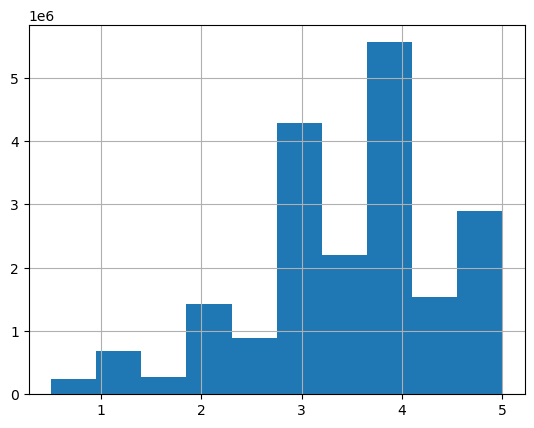

In [2]:
# Distribution des notes
ratings['rating'].hist(bins=10)


In [5]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

# Chargement des données
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file(r'C:\Users\sirin\OneDrive\Bureau\datasets\rating.csv', reader=reader)

# Entraîner un modèle SVD
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7855  0.7869  0.7860  0.7857  0.7860  0.7860  0.0005  
MAE (testset)     0.5979  0.5988  0.5982  0.5979  0.5980  0.5982  0.0004  
Fit time          166.54  174.71  173.77  209.99  338.56  212.71  64.71   
Test time         53.23   56.57   45.50   430.56  65.03   130.18  150.32  


{'test_rmse': array([0.78551179, 0.78690004, 0.78599965, 0.78568943, 0.785975  ]),
 'test_mae': array([0.59788216, 0.59882845, 0.59816144, 0.59786662, 0.59803615]),
 'fit_time': (166.53599405288696,
  174.71046209335327,
  173.7725269794464,
  209.9883418083191,
  338.56415009498596),
 'test_time': (53.22707486152649,
  56.565601110458374,
  45.49978017807007,
  430.5556392669678,
  65.02801322937012)}

In [6]:
trainset = data.build_full_trainset()
algo.fit(trainset)

# Prédiction de la note d'un utilisateur pour un film
uid = str(1)  # ID de l'utilisateur
iid = str(302)  # ID du film

pred = algo.predict(uid, iid)
print(pred.est)


3.5269259364132437


In [7]:
# Films non évalués par l'utilisateur
movie_ids = movies['movieId'].unique()
rated_movie_ids = ratings[ratings['userId'] == int(uid)]['movieId'].values
unrated_movies = [movie for movie in movie_ids if movie not in rated_movie_ids]

# Prédire les notes pour les films non évalués
predictions = [algo.predict(uid, str(movie)) for movie in unrated_movies]
predictions.sort(key=lambda x: x.est, reverse=True)

# Recommander les 5 meilleurs films
top_5_movies = predictions[:5]
print("Top 5 recommandations pour l'utilisateur {} :".format(uid))
for pred in top_5_movies:
    movie_title = movies[movies['movieId'] == int(pred.iid)]['title'].values[0]
    print(movie_title)


Top 5 recommandations pour l'utilisateur 1 :
Frozen Planet (2011)
Prime Suspect (1991)
Very Potter Musical, A (2009)
Welfare (1975)
Bleak House (2005)


In [7]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

# Encoder les userId et movieId pour avoir des indices continus
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings['user'] = user_encoder.fit_transform(ratings['userId'].values)
ratings['movie'] = movie_encoder.fit_transform(ratings['movieId'].values)

# Nombre d'utilisateurs et de films
num_users = ratings['user'].nunique()
num_movies = ratings['movie'].nunique()

# Créer les embeddings avec une taille réduite
embedding_dim = 20  # Réduire la taille des embeddings pour accélérer l'entraînement

user_input = layers.Input(shape=(1,))
user_embedding = layers.Embedding(input_dim=num_users, output_dim=embedding_dim)(user_input)
user_vector = layers.Flatten()(user_embedding)

movie_input = layers.Input(shape=(1,))
movie_embedding = layers.Embedding(input_dim=num_movies, output_dim=embedding_dim)(movie_input)
movie_vector = layers.Flatten()(movie_embedding)

# Calculer la similarité (produit scalaire)
dot_product = layers.dot([user_vector, movie_vector], axes=1)

# Construire le modèle
model = tf.keras.Model(inputs=[user_input, movie_input], outputs=dot_product)
model.compile(optimizer='adam', loss='mean_squared_error')

# Préparer les données
X = [ratings['user'].values, ratings['movie'].values]
y = ratings['rating'].values

# Vérifier si un GPU est disponible
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU detected and memory growth set.")
    except RuntimeError as e:
        print(e)

# Entraînement du modèle avec un batch size plus grand et moins d'epochs
model.fit(X, y, epochs=3, batch_size=128)  # Adjust epochs as needed


Epoch 1/3


C:\Users\sirin\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_7', 'keras_tensor_10']. Received: the structure of inputs=('*', '*')
  warnings.warn(


156253/156253 ━━━━━━━━━━━━━━━━━━━━ 1838s 12ms/step - loss: 3.2529
Epoch 2/3
156253/156253 ━━━━━━━━━━━━━━━━━━━━ 3104s 20ms/step - loss: 0.6612


In [ ]:
# Évaluer le modèle sur l'ensemble de test
test_loss = model.evaluate(X, y)
print(f'Loss on test set: {test_loss}')


   165/625009 ━━━━━━━━━━━━━━━━━━━━ 6:39 639us/step - loss: 0.6383

C:\Users\sirin\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_7', 'keras_tensor_10']. Received: the structure of inputs=('*', '*')
  warnings.warn(


497277/625009 ━━━━━━━━━━━━━━━━━━━━ 1:16 601us/step - loss: 0.6020

In [ ]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    [ratings['user'].values, ratings['movie'].values],
    ratings['rating'].values,
    test_size=0.2,
    random_state=42
)
ol;k;l:ikl
# Entraînement du modèle sur l'ensemble d'entraînement
model.fit(X, y, epochs=3, batch_size=128)

# Évaluer le modèle sur l'ensemble de test
test_loss = model.evaluate(X, y)
print(f'Loss on test set: {test_loss}')

# Prédire une note pour un utilisateur et un film spécifique
user_id = 10  # Example user ID
movie_id = 50  # Example movie ID

# Encoder les identifiants
encoded_user_id = user_encoder.transform([user_id])[0]
encoded_movie_id = movie_encoder.transform([movie_id])[0]

# Prédire la note
predicted_rating = model.predict([[encoded_user_id], [encoded_movie_id]])
print(f'Predicted rating: {predicted_rating[0][0]}')
